In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.signal import argrelmax
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import warnings; warnings.simplefilter('ignore')
import xgboost as xgb
from xgboost import XGBClassifier

%matplotlib inline

In [2]:
file_names = os.listdir('Labeled Data')
file_names

['10-26-18 A3D32M3 brain 1 slide 2.mat',
 '9-13-18 A4D16F3 brain 2 slide 3.mat',
 '8-27-18 A3D16F3 slide 2 brain 1.mat',
 '10-1-18 A4D32M6 brain 1 slide 6.mat',
 '10-9-18 A2D16F3 brain 50um.mat',
 '10-31-18 A2D32M3 Slide 1.mat']

In [3]:
# Read in the data from the labeled spectrum file
data = {}
f = {}

directory = 'Labeled Data'

for file_name in os.listdir(directory):
    f[file_name] = h5py.File(directory + '/' + file_name, 'r')
    data[file_name] = {}
    for k, v in f[file_name].items():
        data[file_name][k] = np.array(v)
    print (f[file_name].items())

ItemsViewHDF5(<HDF5 file "10-26-18 A3D32M3 brain 1 slide 2.mat" (mode r)>)
ItemsViewHDF5(<HDF5 file "9-13-18 A4D16F3 brain 2 slide 3.mat" (mode r)>)
ItemsViewHDF5(<HDF5 file "8-27-18 A3D16F3 slide 2 brain 1.mat" (mode r)>)
ItemsViewHDF5(<HDF5 file "10-1-18 A4D32M6 brain 1 slide 6.mat" (mode r)>)
ItemsViewHDF5(<HDF5 file "10-9-18 A2D16F3 brain 50um.mat" (mode r)>)
ItemsViewHDF5(<HDF5 file "10-31-18 A2D32M3 Slide 1.mat" (mode r)>)


In [4]:
print(data.keys())

dict_keys(['10-26-18 A3D32M3 brain 1 slide 2.mat', '9-13-18 A4D16F3 brain 2 slide 3.mat', '8-27-18 A3D16F3 slide 2 brain 1.mat', '10-1-18 A4D32M6 brain 1 slide 6.mat', '10-9-18 A2D16F3 brain 50um.mat', '10-31-18 A2D32M3 Slide 1.mat'])


5
Brain images at m/z value of 325.1890703925916


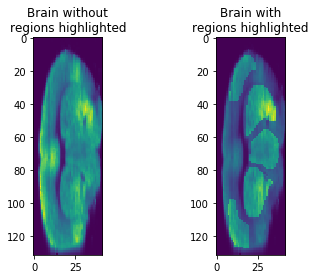

Pixel counts in regions:
left cortex: 231 pixels in region
right cortex: 243 pixels in region
right caudoputamen: 362 pixels in region
left caudoputamen: 368 pixels in region
middle: 322 pixels in region

Total pixels in image: 5544
5
Brain images at m/z value of 834.5715723132982


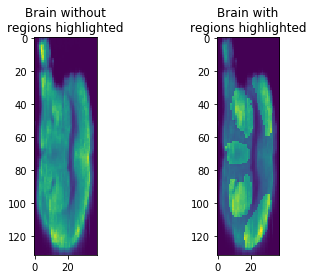

Pixel counts in regions:
left cortex: 322 pixels in region
left caudoputamen: 292 pixels in region
right caudoputamen: 290 pixels in region
middle: 169 pixels in region
right cortex: 272 pixels in region

Total pixels in image: 5016
5
Brain images at m/z value of 834.5411880484747


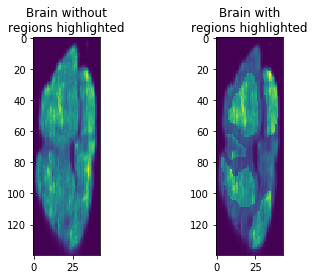

Pixel counts in regions:
left cortex: 328 pixels in region
right cortex: 283 pixels in region
middle: 152 pixels in region
left caudoputamen: 417 pixels in region
right caudoputamen: 532 pixels in region

Total pixels in image: 6020
5
Brain images at m/z value of 325.2121376086753


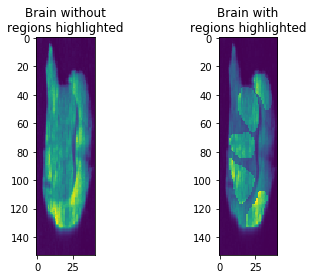

Pixel counts in regions:
left cortex: 226 pixels in region
right cortex: 224 pixels in region
right caudoputamen: 358 pixels in region
left caudoputamen: 332 pixels in region
middle: 262 pixels in region

Total pixels in image: 6273
5
Brain images at m/z value of 834.5847678716045


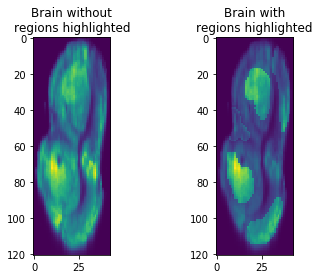

Pixel counts in regions:
left cortex: 289 pixels in region
right cortex: 288 pixels in region
left caudoputamen: 288 pixels in region
right caudoputamen: 297 pixels in region
middle: 129 pixels in region

Total pixels in image: 5203
5
Brain images at m/z value of 325.18822151158065


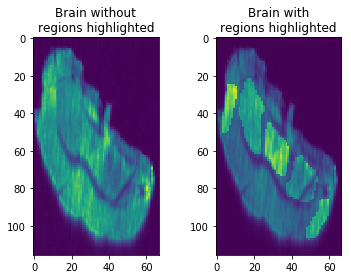

Pixel counts in regions:
right cortex: 135 pixels in region
left cortex: 135 pixels in region
right caudoputamen: 288 pixels in region
left caudoputamen: 356 pixels in region
middle: 254 pixels in region

Total pixels in image: 7772


In [5]:
region_count = {}
region_names = {}
regions = {}
brain_images = {}

colors = ['k', 'r', 'y', 'g', 'b']

for file_name in data:
    # Get the regions from the labeled data file
    region_count[file_name] = int(data[file_name]["ROIcount"])
    print(region_count[file_name])
    regions[file_name] = [np.array([x for x in 
            f[file_name][data[file_name]["ROI"][1,i]]])
            for i in range(region_count[file_name])]

    # Display the brain by displaying abundances at the m/z value that maximizes
    # the abundance at a pixel within the body of the brain
    pixel = (20,20)
    reg = np.where(regions[file_name][0] == 1)
    pixel = (reg[0][0], reg[1][0])
    brain_image = data[file_name]['img'][np.argmax(
            data[file_name]['img'][:,pixel[0],pixel[1]] - 
            data[file_name]['img'][:,0,0]),:,:]
    print("Brain images at m/z value of", data[file_name]["imgZ"][0][np.argmax(
            data[file_name]['img'][:,pixel[0],pixel[1]])])
    plt.subplot(121).imshow(brain_image)
    plt.subplot(121).set_title("Brain without\nregions highlighted")
    plt.subplot(122).imshow(brain_image +
            np.multiply(brain_image, sum(regions[file_name])))
    plt.subplot(122).set_title("Brain with\nregions highlighted")
    plt.show()

    # Initialize containers for the region names and assigned colors
    region_names[file_name] = []

    # Determine region names and amount of pixels in each region
    print("Pixel counts in regions:")
    for i in range(region_count[file_name]):
        region_names[file_name].append((''.join([chr(x[0])
                for x in f[file_name][data[file_name]["ROI"][0,i]]]
                )).lower().replace('.', ''))
        print(region_names[file_name][-1], end=": ")
        print(sum(sum(regions[file_name][i])), "pixels in region")

    # Output the total amount of pixels in the image
    shape = data[file_name]["img"].shape
    print("\nTotal pixels in image:", shape[1]*shape[2])
    brain_images[file_name] = brain_image

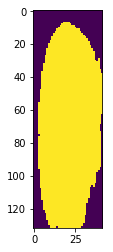

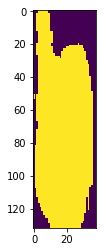

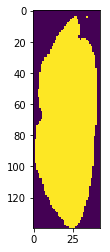

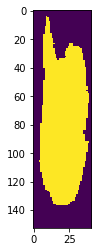

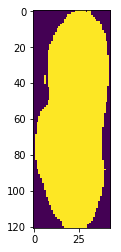

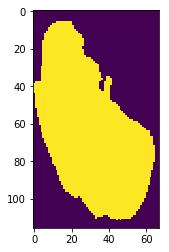

In [6]:
CUTOFF = 7300
for file_name in data:
    plt.imshow(brain_images[file_name] > CUTOFF)
    plt.show()

In [7]:
xSize, ySize, zSize = {}, {}, {}
image_filter = {}
region_pixel_counts = {}
overall_average = {}
overall_n = 0
file_n = {}
for file_name in data:
    print(file_name)
    (xSize[file_name], ySize[file_name],
            zSize[file_name]) = data[file_name]['img'].shape
    n = 0
    image_filter[file_name] = (brain_images[file_name] > CUTOFF)
    region_pixel_counts[file_name] = [0
            for i in range(len(regions[file_name]) + 1)]
    overall_average[file_name] = np.zeros(xSize[file_name])

    for i in range(ySize[file_name]):
        for j in range(zSize[file_name]):
            if image_filter[file_name][i,j]:
                spectrum = data[file_name]['img'][:,i,j]
                in_region = False
                for r in range(len(regions[file_name])):
                    if regions[file_name][r][i,j] > 0:
                        in_region = True
                        region_pixel_counts[file_name][r] += 1
                        break
                if not in_region:
                    region_pixel_counts[file_name][-1] += 1
                overall_average[file_name] += spectrum

            if n % 100 == 0:
                print("Finished reading", n, "out of",
                        ySize[file_name]*zSize[file_name], "pixels", end="\r")

            n += 1

    overall_n += n
    file_n[file_name] = n
    overall_average[file_name] /= sum(region_pixel_counts[file_name])

    print(region_pixel_counts[file_name], " "*40)

10-26-18 A3D32M3 brain 1 slide 2.mat
[231, 243, 362, 368, 322, 2434]                                         
9-13-18 A4D16F3 brain 2 slide 3.mat
[322, 292, 290, 169, 272, 2306]                                         
8-27-18 A3D16F3 slide 2 brain 1.mat
[328, 283, 152, 417, 532, 2263]                                         
10-1-18 A4D32M6 brain 1 slide 6.mat
[226, 219, 358, 332, 262, 1857]                                         
10-9-18 A2D16F3 brain 50um.mat
[289, 288, 288, 297, 127, 2450]                                         
10-31-18 A2D32M3 Slide 1.mat
[135, 135, 288, 356, 254, 2908]                                         


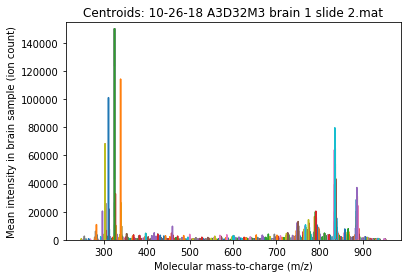

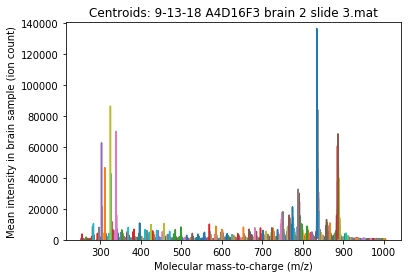

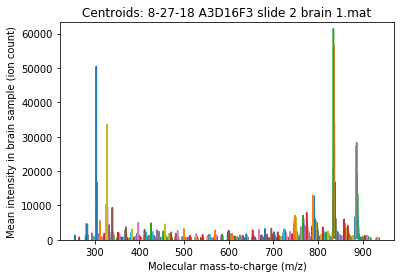

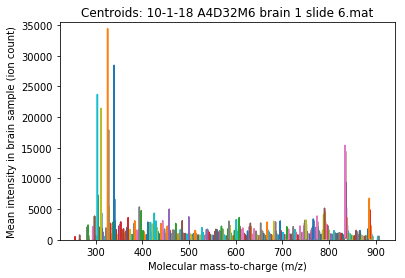

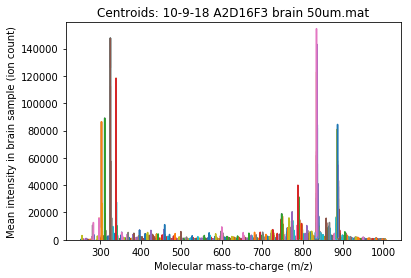

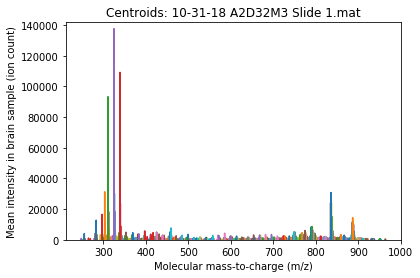

In [8]:
census_maxima = {}
imgZ = {}
MINIMUM_INTENSITY = 500

for file_name in data:
    imgZ[file_name] = data[file_name]["imgZ"][0]
    region_names[file_name].append("brain other")

    spectrum = overall_average[file_name]
    maxima = argrelmax(spectrum)[0]
    maxima = maxima[spectrum[maxima] > MINIMUM_INTENSITY]
    sort = np.argsort(spectrum[maxima])
    for s in maxima[sort]:
        indices = list(range(s-20, s+20))
        plt.plot([imgZ[file_name][i] for i in indices],
                [spectrum[i] for i in indices])
    plt.title("Centroids: " + file_name)
    plt.xlabel("Molecular mass-to-charge (m/z)")
    plt.ylabel("Mean intensity in brain sample (ion count)")
    plt.ylim(0, np.max(spectrum[maxima])*1.03)
    plt.show()
    maxima = maxima[sort]
    census_maxima[file_name] = set(maxima)

In [9]:
maxima = set([])
for file_name in data:
    maxima = maxima.intersection(census_maxima[file_name])

In [10]:
len(maxima)

0

In [11]:
maxima_list = {}
for file_name in data:
    print(len(census_maxima[file_name]))
    maxima_list[file_name] = np.array(sorted(census_maxima[file_name]))

783
1231
563
632
1277
655


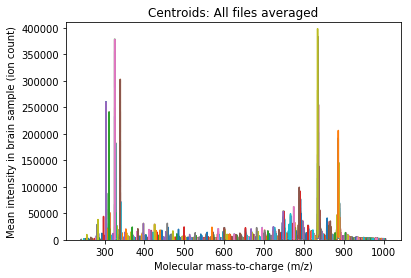

In [12]:
MAXIMUM_PEAK_COUNT = 500

overall_overall_average = None
first = True
for file_name in data:
    if first:
        overall_overall_average = np.zeros_like(overall_average[file_name])
        first = False
    overall_overall_average += overall_average[file_name]

for file_name in data:
    imgZ = data[file_name]["imgZ"][0]
    spectrum = overall_overall_average
    maxima = argrelmax(spectrum)[0]
    maxima = maxima[spectrum[maxima] > MINIMUM_INTENSITY]
    sort = np.argsort(spectrum[maxima])
    for s in maxima[sort]:
        indices = list(range(s-20, s+20))
        plt.plot([imgZ[i] for i in indices],
                [spectrum[i] for i in indices])
    plt.title("Centroids: All files averaged")
    plt.xlabel("Molecular mass-to-charge (m/z)")
    plt.ylabel("Mean intensity in brain sample (ion count)")
    plt.ylim(0, np.max(spectrum[maxima])*1.03)
    plt.show()
    sort = sort[-MAXIMUM_PEAK_COUNT:]
    maxima = maxima[sort]
    census_maxima = set(maxima)
    break

In [13]:
print(len(census_maxima))
maxima_list = np.array(sorted(census_maxima))

500


In [14]:
maxima_values = np.array([imgZ[m] for m in maxima_list])
all_labels = np.array([None]*overall_n)
file_labels = {f:np.array([None]*file_n[f]) for f in data}
all_numbered_labels = np.array([-1]*overall_n)
file_numbered_labels = {f:np.array([-1]*file_n[f]) for f in data}

In [15]:
overall_n

35828

In [16]:
all_spectra = np.zeros((overall_n, len(maxima_list)))
file_spectra = {f:np.zeros((file_n[f], len(maxima_list))) for f in data}

a = 0

for file_name in data:
    f = 0
    print(file_name)
    for i in range(ySize[file_name]):
        for j in range(zSize[file_name]):
            spectrum = data[file_name]['img'][:,i,j][maxima_list]
            all_spectra[a] = spectrum
            file_spectra[f] = spectrum
            labeled = False
            for r in range(region_count[file_name]):
                if regions[file_name][r][i,j] == 1:
                    all_labels[a] = region_names[file_name][r]
                    file_labels[file_name][f] = region_names[file_name][r]
                    all_numbered_labels[a] = r
                    file_numbered_labels[file_name][f] = r
                    labeled = True
            if not labeled:
                all_labels[a] = ("brain other" if
                        brain_images[file_name][i,j] > CUTOFF else "not brain")
                file_labels[file_name][f] = ("brain other" if
                        brain_images[file_name][i,j] > CUTOFF else "not brain")
                all_numbered_labels[a] = (5 if
                        brain_images[file_name][i,j] > CUTOFF else 6)
                file_numbered_labels[file_name][f] = (5 if
                        brain_images[file_name][i,j] > CUTOFF else 6)

            if s % 100 == 0:
                print("Finished reading", s, "rows", end="\r")

            a += 1
            f += 1

10-26-18 A3D32M3 brain 1 slide 2.mat
9-13-18 A4D16F3 brain 2 slide 3.mat
8-27-18 A3D16F3 slide 2 brain 1.mat
10-1-18 A4D32M6 brain 1 slide 6.mat
10-9-18 A2D16F3 brain 50um.mat
10-31-18 A2D32M3 Slide 1.mat


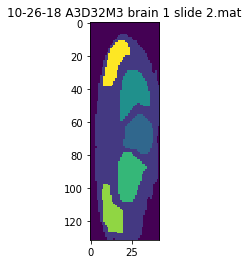

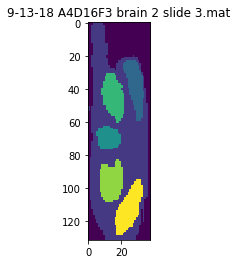

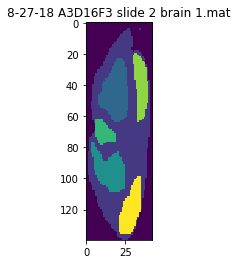

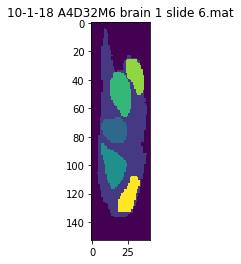

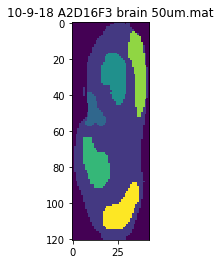

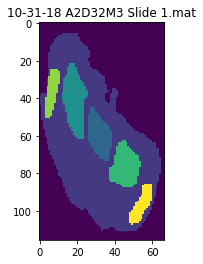

In [17]:
for file_name in data:
    plt.imshow(6 - file_numbered_labels[file_name].reshape(
            ySize[file_name], zSize[file_name]))
    plt.title(file_name)
    plt.show()

In [18]:
all_labels[all_labels == 'right caudoputamen'] = 'caudoputamen'
all_labels[all_labels == 'left caudoputamen'] = 'caudoputamen'
all_labels[all_labels == 'right cortex'] = 'cortex'
all_labels[all_labels == 'left cortex'] = 'cortex'

for f in data:
    file_labels[f][file_labels[f] == 'right caudoputamen'] = 'caudoputamen'
    file_labels[f][file_labels[f] == 'left caudoputamen'] = 'caudoputamen'
    file_labels[f][file_labels[f] == 'right cortex'] = 'cortex'
    file_labels[f][file_labels[f] == 'left cortex'] = 'cortex'

test_file = np.random.choice([f for f in data])
test_file

'10-26-18 A3D32M3 brain 1 slide 2.mat'

In [32]:
X, y = [], []
for file_name in data:
    data_filter = (file_labels[file_name] != "not brain")
    if file_name != test_file:
        X.append(file_spectra[file_name][data_filter])
        y.append(np.matrix(file_labels[file_name][data_filter]).T)
x_train = np.vstack(tuple(X))
y_train = np.array(np.vstack(tuple(y)).T)[0]

data_filter = (file_labels[test_file] != "not brain")
x_test = file_spectra[test_file][data_filter]
y_test = file_labels[test_file][data_filter]

set(y_test)

{'brain other', 'caudoputamen', 'cortex', 'middle'}

In [33]:
solver = 'newton-cg'
clf = LogisticRegression(solver=solver,
        multi_class='multinomial').fit(x_train, y_train)
prediction = clf.predict(x_test)
mistakes = len(y_test[prediction != y_test])
print('Using the', solver, 'solver, there were', mistakes, 'mistakes',
     'out of', len(y_test), 'data points.')

Using the newton-cg solver, there were 1526 mistakes out of 3960 data points.


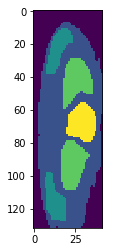

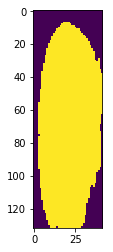

{'brain other'}

In [39]:
predict_copy = prediction.copy()
actual_copy = y_test.copy()

predict_image = np.zeros((ySize[test_file], zSize[test_file]))
actual_image = np.zeros((ySize[test_file], zSize[test_file]))

str_to_num = {'brain other':1, 'cortex':2, 'caudoputamen':3, "middle":4}

for s in str_to_num:
    predict_copy[predict_copy == s] = str_to_num[s]
    actual_copy[actual_copy == s] = str_to_num[s]

image_index = 0
data_index = 0
for i in range(ySize[test_file]):
    for j in range(zSize[test_file]):
        if file_labels[test_file][image_index] != "not brain":
            predict_image[i,j] = predict_copy[data_index]
            actual_image[i,j] = actual_copy[data_index]
            data_index += 1
        image_index += 1

plt.imshow(actual_image)
plt.show()
plt.imshow(predict_image)
plt.show()
set(prediction)

In [40]:
model = XGBClassifier()
model.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [41]:
prediction = model.predict(x_test)
mistakes = len(y_test[prediction != y_test])
print('Using XGBoost, there were', mistakes, 'mistakes',
     'out of', len(y_test), 'data points.')

Using XGBoost, there were 1526 mistakes out of 3960 data points.


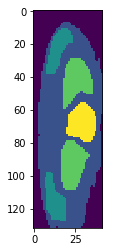

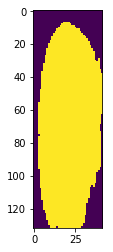

{'brain other'}

In [42]:
predict_copy = prediction.copy()
actual_copy = y_test.copy()

predict_image = np.zeros((ySize[test_file], zSize[test_file]))
actual_image = np.zeros((ySize[test_file], zSize[test_file]))

str_to_num = {'brain other':1, 'cortex':2, 'caudoputamen':3, "middle":4}

for s in str_to_num:
    predict_copy[predict_copy == s] = str_to_num[s]
    actual_copy[actual_copy == s] = str_to_num[s]

image_index = 0
data_index = 0
for i in range(ySize[test_file]):
    for j in range(zSize[test_file]):
        if file_labels[test_file][image_index] != "not brain":
            predict_image[i,j] = predict_copy[data_index]
            actual_image[i,j] = actual_copy[data_index]
            data_index += 1
        image_index += 1

plt.imshow(actual_image)
plt.show()
plt.imshow(predict_image)
plt.show()
set(prediction)